# Neural Network classification with PyTorch

Classification is a problem of prediction whether something is one thing or another (there can be multiple things as the options).

## 1. Make classification data and get it ready

In [62]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [63]:
len(X), len(y)

(1000, 1000)

In [64]:
print(f"First 5 samples of X:\n{X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [65]:
# Make DataFrame of circles data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "Label": y})
circles.head(10)

,X1,X2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


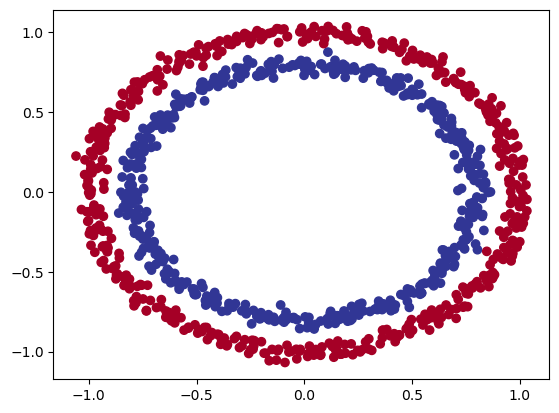

In [66]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

**Note:** The data we're workinbg with is often referred ta as a toy, deataset, a dataset that is small enought to experiment, but still sizeable enought to practice the fundamentals.

### 1.1 Check input and output shapes

In [67]:
X.shape, y.shape

((1000, 2), (1000,))

In [68]:
# View the first example of features and labels
X_shample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_shample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X {X_shample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits


In [69]:
# Turn data into tensors
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [70]:
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [71]:
# Split the data into training sets
from sklearn.model_selection import train_test_split

XTrain, XTest, YTrain, YTest = train_test_split(X,
                                                y,
                                                test_size=0.2, # 0.2 reprecents 20% of data will be test & 80% will be train
                                                random_state=42)

In [72]:
len(XTrain), len(XTest), len(YTrain), len(YTest)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if ther is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [73]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device.upper()}")

Using device CPU


Now we've setup device agnostic code, let's create a model thet:

1. Subclasses `nn.Module` (almouts all models in PyTorch subclasses `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instatiate an instance of ur model class and sen it ti the target `device`

In [74]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling our shapes of our data
    self.layer1 = nn.Linear(in_features=2, # Takes 2 features and upscales to 5 features
                            out_features=5)
    self.layer2 = nn.Linear(in_features=5, # Takes in 5 features from previous layer and outputs a single feature (same shape as y)
                            out_features=1)
  #Define a forward() method tha outlines a forward pass
  def forward(self,x):
    return self.layer2(self.layer1(x)) # x -> layer1 -> layer2 -> output
  
#4. Instanciate an instance of ur model class and send it to the target device
model0 = CircleModelV0().to(device=device)
model0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [75]:
# Let's replicate the model above using nn.Secuential()
model0 = nn.Sequential(
  nn.Linear(in_features=2, # Takes 2 features and upscales to 5 features
            out_features=5),
            
  nn.Linear(in_features=5, # Takes in 5 features from previous layer and outputs a single feature (same shape as y)
            out_features=1),
).to(device)


In [76]:
model0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5558, -0.3740],
                      [ 0.3085, -0.5235],
                      [-0.2766,  0.4836],
                      [-0.6227, -0.4335],
                      [-0.0201, -0.6433]])),
             ('0.bias', tensor([-0.1687,  0.3466,  0.3214,  0.3776,  0.1245])),
             ('1.weight',
              tensor([[-0.0303,  0.2508,  0.0474, -0.4330, -0.3684]])),
             ('1.bias', tensor([0.0743]))])

In [77]:
# Make Prediction
with torch.inference_mode():
  untrainedModelPreds = model0(XTest.to(device))


untrainedModelPreds[:10], XTest[:10], YTest[:10]

(tensor([[ 0.0742],
         [ 0.2918],
         [-0.3589],
         [ 0.1963],
         [-0.1409],
         [-0.0097],
         [ 0.4302],
         [ 0.3602],
         [-0.3675],
         [ 0.3088]]),
 tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use ?

Again... this is problem specific.

For example for regretion you might want MAE ir MSE (mean absolute error or mean square error).

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, a loss function measures how wrong your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For the loss function we're going to use torch.nn.`BECEWithLogitsLoss()`.

In [78]:
# Setup loss function
# lossFN = nn.BCELoss() # BCELoss = requires inputs to have gone trought the sigmoin activation function prior to imput the BCELoss
lossFN = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.01)

In [79]:
# Calculate accuracy -out of 100 examples, what percentage does our model get right?
def accuracyFN(YTrue, YPred):
  correct = torch.eq(YTrue,YPred).sum().item()
  return (correct/len(YPred)) * 10

## 3. Train model

To train a model, we're going to need to build a training loop with the folowign steps:
1. Foward pass
2. Calculate the loss
3. Optimize zero grad
4. Loss backward (backpropagtion)
5. Optimizer (Gradient decent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are goin to be raw **Logits**.

We can convert thease **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for banary classification and softmax for multiclass clasification). 

The we can conver our model's predictions probabilities to **Predictions labels** by either rounding them or taking the `argmax()`.

In [80]:
# View the first 5 outputs of the foward pass on the test data
model0.eval()
with torch.inference_mode():
  YLogits = model0(XTest.to(device))[:5]
YLogits

tensor([[ 0.0742],
        [ 0.2918],
        [-0.3589],
        [ 0.1963],
        [-0.1409]])

In [81]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
YPredProbs = torch.sigmoid(YLogits)
YPredProbs

tensor([[0.5185],
        [0.5724],
        [0.4112],
        [0.5489],
        [0.4648]])

In [82]:
torch.round(YPredProbs)

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.]])

For our prediction probability values, we need to perform a range-style rounding on them:
* `YpredProbs` >= 0.5, `y=1` (class 1)
* `YpredProbs` < 0.5, `y=0` (class 0)

In [83]:
# Find the predicted labels
YPred = torch.round(YPredProbs)

# In full (logits -> pred probs -> pred labels)
YpredLabels = torch.round(torch.sigmoid(model0(XTest.to(device))[:5]))

# Chek for equality 
print(torch.eq(YPred.squeeze(),YpredLabels.squeeze()))

YPred.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 0., 1., 0.])

In [84]:
YTest[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [85]:
# torch.manual_seed(42)

# epochs = 80000

# # Put data into the target device 
# XTrain, YTrain, XTest, YTest = XTrain.to(device), YTrain.to(device), XTest.to(device), YTest.to(device)

# # Build training and evaluating loop

# for epoch in range(epochs):
#   ## Training
#   model0.train()

#   # 1. Foward pass
#   YLogits = model0(XTrain).squeeze()
#   Ypred = torch.round(torch.sigmoid(YLogits)) # turn logits -> pred probs ->pred labels

#   # 2. Calcualte loss/accuracy
#   # loss = lossFN(torch.sigmoid(YLogits), # nn.BCELoss expects prediction probabilities as input
#   #               YTrain)
  
#   loss = lossFN(YLogits,        # nn.BCEWithLogitsLoss expects raw logits as input 
#                 YTrain)
#   acc = accuracyFN(YTrain,Ypred)
  
#   # 3. Optimizer zero grad
#   optimizer.zero_grad()

#   # 4. Loss backward (backPropagation)
#   loss.backward()

#   # 5. Optimizer step (gradent decent)
#   optimizer.step()

#   ### Testing 
#   model0.eval()
#   with torch.inference_mode():
#     # 1. Foward pass
#     TestLogits = model0(XTest).squeeze()
#     TestPred = torch.round(torch.sigmoid(TestLogits))

#     # 2. Calculate test los/ accuracy
#     TestLoss = lossFN(TestLogits,
#                       YTest)
    
#     TestAcc = accuracyFN(YTest,TestPred)
    
#     # Print out what's happenin'
#     if (epoch % 10000 == 0):
#       print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {TestLoss:.5f}, TestAcc: {TestAcc:.2f}%")

## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't leanrning anything...

So to inspect is let's make predictions and make them visual!

In other words "visulize, visualize, visualize".

To do so, we're going to import a function calles `plot_decision_boundry()`

In [86]:
import requests
from pathlib import Path

url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"

if Path("helper_functions.py").is_file():
  print("helper_functions.py alredy exist, skiping...")
else:
  print("Download helper functions.py")
  request = requests.get(url)
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import *

helper_functions.py alredy exist, skiping...


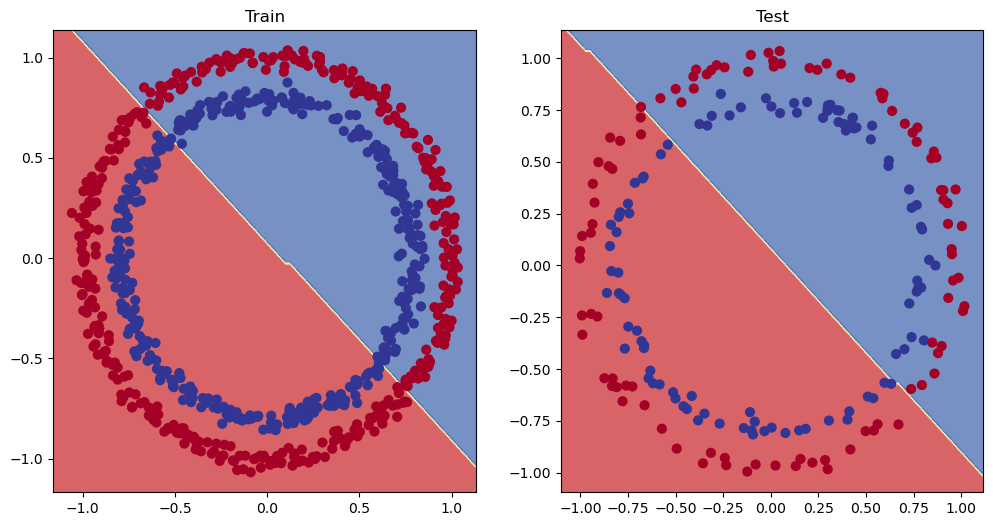

In [87]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0,XTrain,YTrain)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0,XTest,YTest)

## 5. Improve a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in teh data
* Add more hidden units - go from 5 hidden units to 10 hidden
* Fit for longer
* Changing the activation functions
* Change the learning rate

This options are all from a model's perspective because thewy deal directly with the model, no with the data.

And because thease options are all values we (as mashine learning engineers adn data scientists) can change, they are refered as ****hyerparameters****.

Let's try and improve our model by:
* Adding hidden units: 5 -> 10
* Increase the number fo layers 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [88]:
import torch
from torch import nn


class CircleModelV1(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.layer1 = nn.Linear(2,10)
    self.layer2 = nn.Linear(10,10)
    self.layer3 = nn.Linear(10,1)

  def forward(self,x):
    # z = self.layer1(x)
    # z = self.layer1(z)
    # z = self.layer1(z)
    return self.layer3(self.layer2(self.layer1(x))) # this way of writing operations leverages speed ups where possible behind the scenes
  
model1 = CircleModelV1().to(device)
model1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [89]:
# Create a loss function

lossFN = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr = 0.001)


In [90]:
# Write a training and evaluation loop for model1
torch.manual_seed(42)
torch.cuda.manual_seed(42) 

# Train for longer
epochs = 1000

# Put data on the target device
XTrain, YTrain = XTrain.to(device), YTrain.to(device)
XTest, YTest = XTest.to(device), YTest.to(device)

for epoch in range(epochs):
  ### Training
  model1.train()
  # 1. Forward pass
  y_logits = model1(XTrain).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> prediction labels

  # 2. Calculate the loss/acc
  loss = lossFN(y_logits, YTrain)
  acc = accuracy_fn(y_true=YTrain,
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad() 

  # 4. Loss backward (backpropagation) 
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model1(XTest).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits)) 
    # 2. Calculate loss
    TestLoss = lossFN(test_logits,
                        YTest)
    TestAcc = accuracy_fn(y_true=YTest,
                           y_pred=test_pred)

  # Print out what's happenin'
  if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {TestLoss:.5f}, TestAcc: {TestAcc:.2f}%")

Epoch: 0 | Loss: 0.69411, Acc: 47.12% | Test Loss: 0.69178, TestAcc: 52.00%
Epoch: 100 | Loss: 0.69408, Acc: 47.50% | Test Loss: 0.69177, TestAcc: 52.00%
Epoch: 200 | Loss: 0.69405, Acc: 47.38% | Test Loss: 0.69176, TestAcc: 52.00%


Epoch: 300 | Loss: 0.69403, Acc: 47.12% | Test Loss: 0.69176, TestAcc: 52.50%
Epoch: 400 | Loss: 0.69401, Acc: 47.38% | Test Loss: 0.69176, TestAcc: 53.50%
Epoch: 500 | Loss: 0.69399, Acc: 47.62% | Test Loss: 0.69176, TestAcc: 53.00%
Epoch: 600 | Loss: 0.69397, Acc: 47.88% | Test Loss: 0.69176, TestAcc: 53.00%
Epoch: 700 | Loss: 0.69395, Acc: 47.88% | Test Loss: 0.69176, TestAcc: 53.00%
Epoch: 800 | Loss: 0.69393, Acc: 48.25% | Test Loss: 0.69176, TestAcc: 53.00%
Epoch: 900 | Loss: 0.69391, Acc: 48.50% | Test Loss: 0.69177, TestAcc: 52.50%


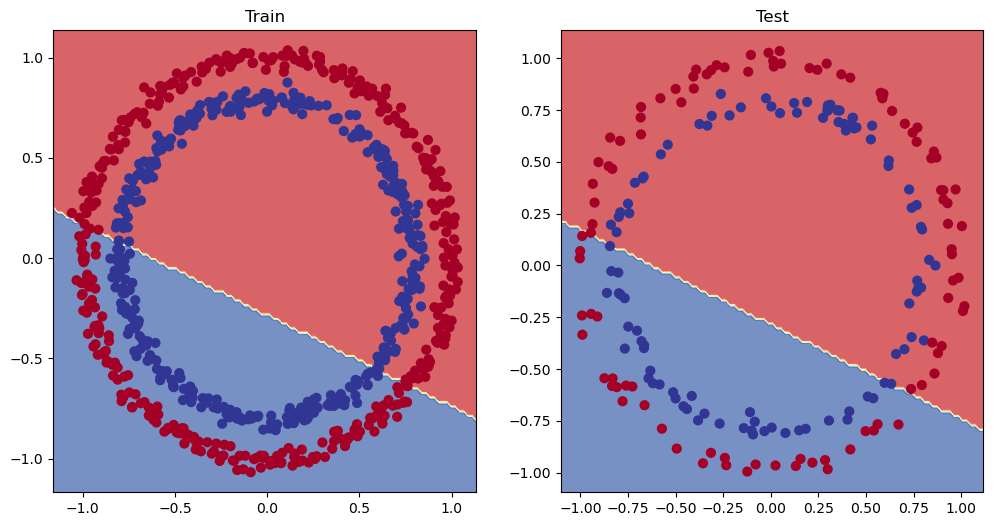

In [91]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model1,XTrain,YTrain)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model1,XTest,YTest)

### Preparing data to see if our model can fit a straight line

One way to troubleshoot a loarger probles is to test out a smaller problem

In [92]:
import torch
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1 
step = 0.01

# Create data
XRegression = torch.arange(start,end,step).unsqueeze(1)
YRegression = weight * XRegression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(XRegression))
XRegression[:5], YRegression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [93]:
# Create train and test splits
train_split = int (len(XRegression) * 0.8)
XTrainRegression, YTrainRegression = XRegression[:train_split], YRegression[:train_split]
XTestRegression, YTestRegression = XRegression[train_split:], YRegression[train_split:]


# Check the lenghts of each
len(XTrainRegression),len(YTrainRegression),len(XTestRegression),len(YTestRegression)

(80, 80, 20, 20)

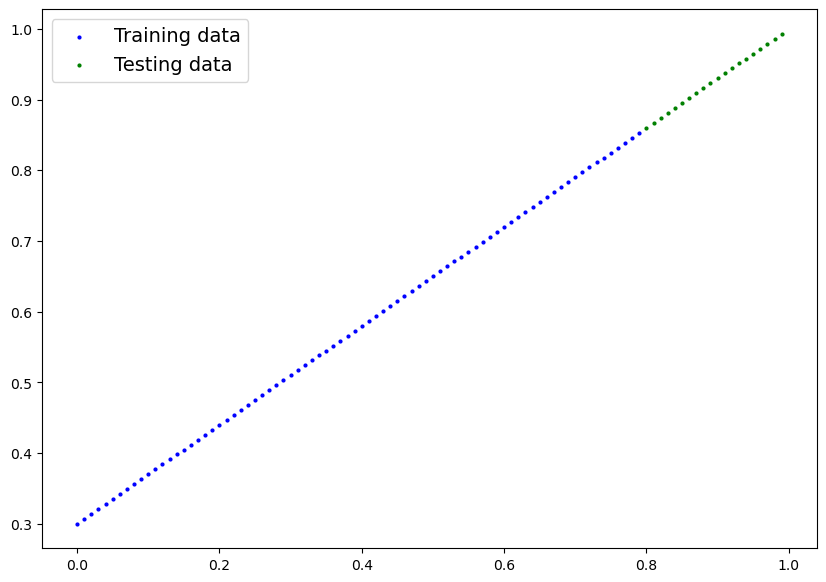

In [94]:
plot_predictions(train_data=XTrainRegression,
                 train_labels=YTrainRegression,
                 test_data=XTestRegression,
                 test_labels=YTestRegression)

### 5.2 Adjusting `model1` to fit a straight line

In [95]:
# Same architecture as model1 (bus using 1 input layer and nn.Sequential())

model2 = nn.Sequential(
  nn.Linear(in_features=1,out_features=10),
  nn.Linear(in_features=10,out_features=10),
  nn.Linear(in_features=10,out_features=1)
).to(device)
model2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [96]:
# Loss and optimizer

LossFN2 = nn.L1Loss()
optimizer2 = torch.optim.SGD(params=model2.parameters(),
                             lr=0.001)

In [97]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs

epochs = 10000

# Put the data on the target device
XTrainRegression, YTrainRegression, XTestRegression,YTestRegression = XTrainRegression.to(device), YTrainRegression.to(device), XTestRegression.to(device),YTestRegression.to(device)

# Training 
model2.train()
for epoch in range(epochs):
  YPred = model2(XTrainRegression)

  loss = LossFN2(YPred,YTrainRegression)

  optimizer2.zero_grad()
  
  loss.backward()

  optimizer2.step()

  # Testing
  model2.eval()

  with torch.inference_mode():
    TestPred = model2(XTestRegression)
    TestLoss = LossFN2(TestPred,YTestRegression)

  # Print out what's happenin'
  if epoch % 1000 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {TestLoss:.5f}")


Epoch: 0 | Loss: 0.75986 | Test Loss: 0.94965


Epoch: 1000 | Loss: 0.00289 | Test Loss: 0.00015
Epoch: 2000 | Loss: 0.00256 | Test Loss: 0.00026
Epoch: 3000 | Loss: 0.00218 | Test Loss: 0.00032
Epoch: 4000 | Loss: 0.00222 | Test Loss: 0.00039
Epoch: 5000 | Loss: 0.00220 | Test Loss: 0.00040
Epoch: 6000 | Loss: 0.00215 | Test Loss: 0.00034
Epoch: 7000 | Loss: 0.00219 | Test Loss: 0.00036
Epoch: 8000 | Loss: 0.00212 | Test Loss: 0.00031
Epoch: 9000 | Loss: 0.00219 | Test Loss: 0.00039


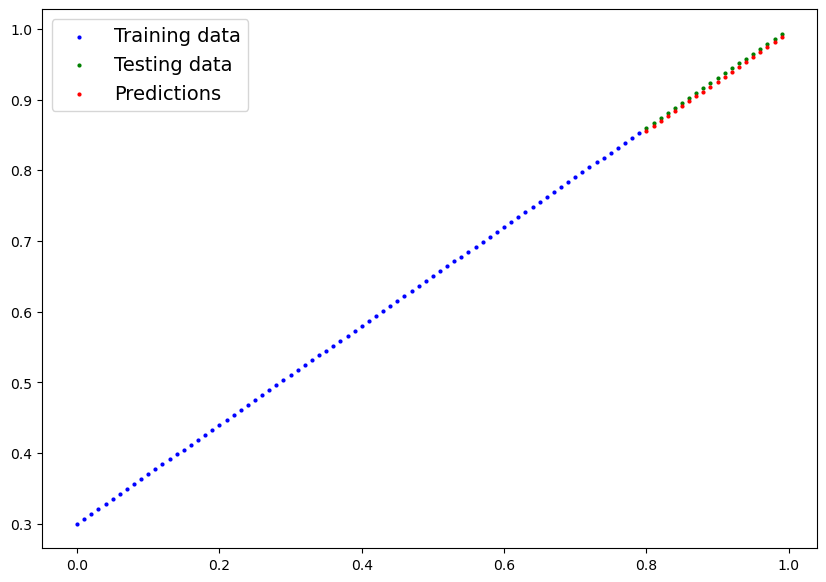

In [98]:
# Turn on evaluation mode
model2.eval()

# Make predictions (inference)

with torch.inference_mode():
  YPreds = model2(XTestRegression)

plot_predictions(train_data=XTrainRegression,
                 train_labels=YTrainRegression,
                 test_data=XTestRegression,
                 test_labels=YTestRegression,
                 predictions=YPreds)

## 5. The mising piece of our model 

"What patterns could you draw if you were given and infinite amount of staight and non-straing lines?"

Or in machine learning terms, an infinite (but really it is finite) if linear and non-linear functions?

### 6.1 Recreating non-liner data (red and blue circles)

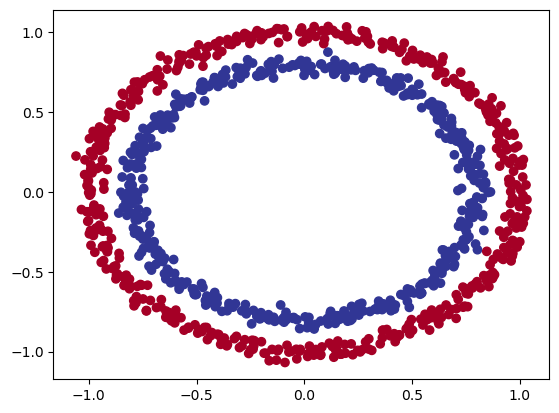

In [99]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0],X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [100]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
XTrain, XTest, YTrain, YTest = train_test_split(X,
                                                y,
                                                test_size=0.2,
                                                random_state=42)
XTrain[:5], YTrain[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Build a model with non-linearity

* Linear = straght line
* Non-Linear = non-straignt line 

In [101]:
# Build a model with non-linear activation functions
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.layer1 = nn.Linear(2,10)
    self.layer2 = nn.Linear(10,10)
    self.layer3 = nn.Linear(10,1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self,x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
  
model3 = CircleModelV2().to("cpu")
model3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [102]:
lossFN = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model3.parameters(),
                            lr = 0.01)

In [103]:
### Training a model with non-linearity

# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device.upper()}")

Using device CPU


In [104]:
# randoim seeds 
torch.manual_seed(42)

# Put all data on target device 
XTrain, YTrain, XTest, YTest = XTrain.to(device), YTrain.to(device), XTest.to(device), YTest.to(device)

# Loop through data 
epochs = 15000

for epoch in range(epochs):
  ### Training 
  model3.train()

  # 1. Foward pass
  YLogits = model3(XTrain).squeeze()
  YPred = torch.round(torch.sigmoid(YLogits)) # Logits -> Prediction Probabilities -> Prediction labels
  #2. Calculate the loss
  loss = lossFN(YLogits,YTrain)

  acc = accuracy_fn(YTrain,
                    YPred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer 
  optimizer.step()

  ### Testing 
  model3.eval()

  with torch.inference_mode():
    testLogits = model3(XTest).squeeze()
    testPred = torch.round(torch.sigmoid(testLogits))

    testLoss = lossFN(testLogits,YTest)
    testAcc = accuracy_fn(YTest,
                          TestPred)
    
    # Print out
    if epoch % 1000 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {testLoss:.4f}, Test Acc: {testAcc:.2f}%")

Epoch: 0 | Loss: 0.6929, Acc: 50.00% | Test Loss: 0.6932, Test Acc: 0.00%
Epoch: 1000 | Loss: 0.6912, Acc: 53.00% | Test Loss: 0.6910, Test Acc: 0.00%
Epoch: 2000 | Loss: 0.6898, Acc: 53.37% | Test Loss: 0.6894, Test Acc: 0.00%
Epoch: 3000 | Loss: 0.6879, Acc: 53.00% | Test Loss: 0.6872, Test Acc: 0.00%
Epoch: 4000 | Loss: 0.6852, Acc: 52.75% | Test Loss: 0.6841, Test Acc: 0.00%
Epoch: 5000 | Loss: 0.6810, Acc: 52.75% | Test Loss: 0.6794, Test Acc: 0.00%
Epoch: 6000 | Loss: 0.6751, Acc: 54.50% | Test Loss: 0.6729, Test Acc: 0.00%
Epoch: 7000 | Loss: 0.6665, Acc: 58.38% | Test Loss: 0.6632, Test Acc: 0.00%
Epoch: 8000 | Loss: 0.6514, Acc: 64.00% | Test Loss: 0.6476, Test Acc: 0.00%
Epoch: 9000 | Loss: 0.6232, Acc: 74.00% | Test Loss: 0.6214, Test Acc: 0.00%
Epoch: 10000 | Loss: 0.5672, Acc: 88.00% | Test Loss: 0.5735, Test Acc: 0.00%
Epoch: 11000 | Loss: 0.4800, Acc: 93.50% | Test Loss: 0.4989, Test Acc: 0.00%
Epoch: 12000 | Loss: 0.3688, Acc: 98.00% | Test Loss: 0.4053, Test Acc: 0.00%

In [105]:
# Make Predictions
model3.eval()
with torch.inference_mode():
  YPreds = torch.round(torch.sigmoid(model3(XTest))).squeeze()

YPreds == YTest

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

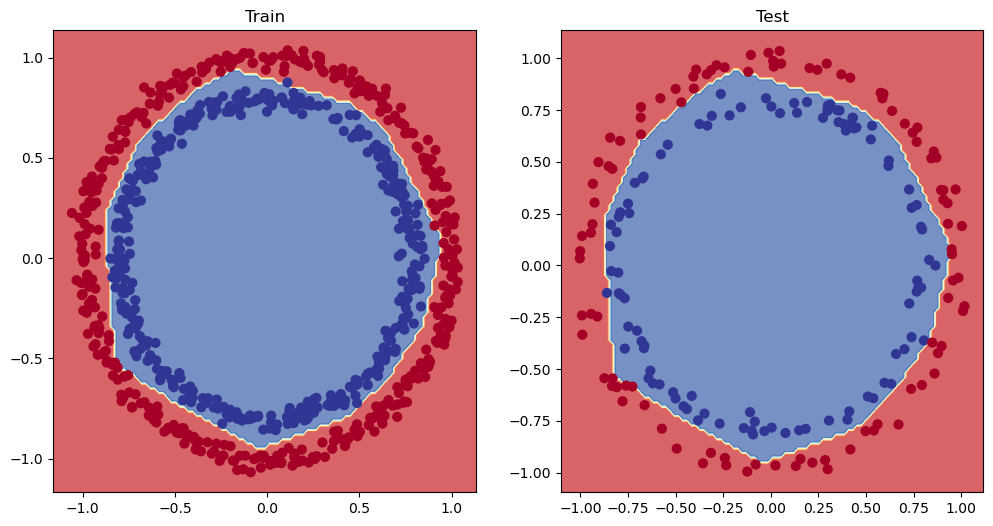

In [106]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model3,XTrain,YTrain)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model3,XTest,YTest)

### 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to rearn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And thease tools are linear & non-linear functions.

In [107]:
# Create a tensor 
A = torch.arange(-10,10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

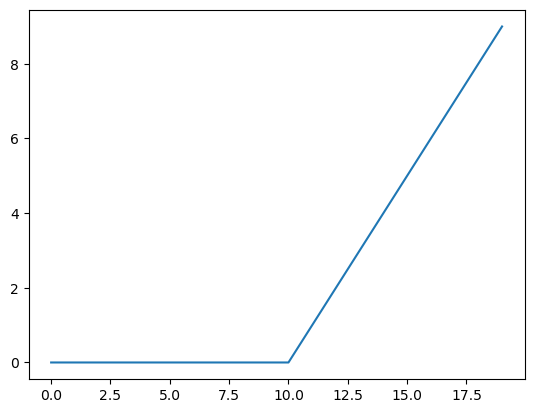

In [108]:
# Visualize the tensor
plt.plot(torch.relu(A))

In [109]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0),x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

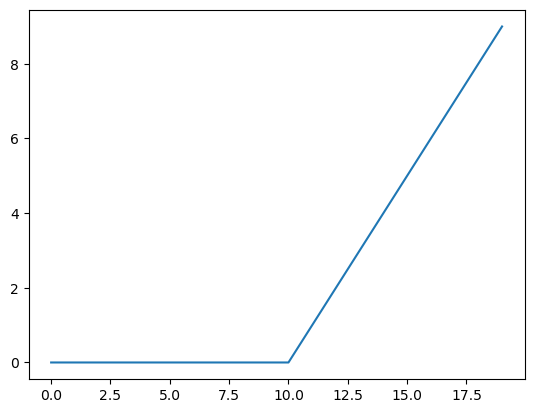

In [110]:
# Plot ReLU activation function
plt.plot(relu(A))

In [111]:
# Now let's do the same for sigmoid

def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))


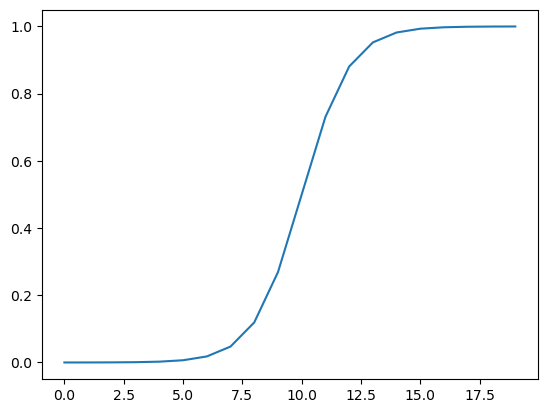

In [112]:
plt.plot(sigmoid(A))

### 8. Putting all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs. dog, spam vs. no spam)

* Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)

## 8.1 Create a toy multi-class dataset

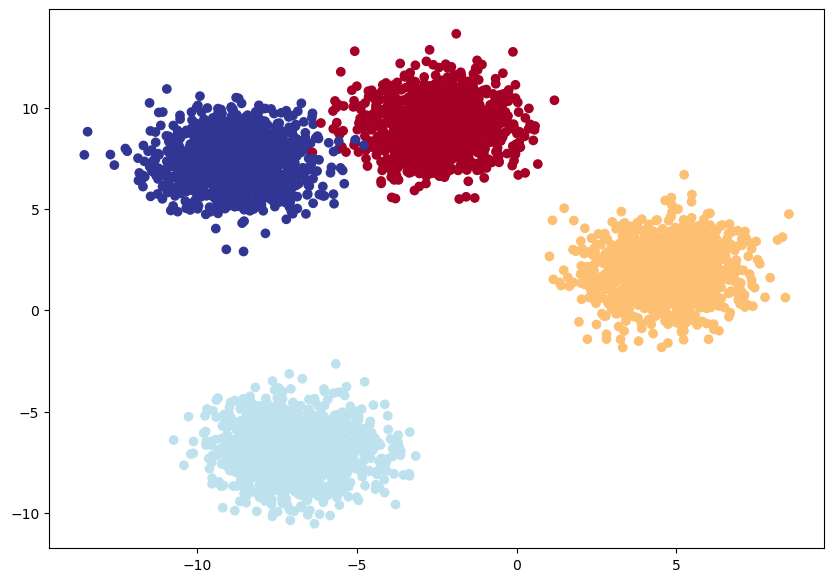

In [199]:
# Import deepncencies
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparameters for data creation
NUN_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
XBlob, YBlob = make_blobs(n_samples=5000,
                          n_features=NUM_FEATURES,
                          centers=NUN_CLASSES,
                          cluster_std=1.2,# Give the clusters shake a bit
                          random_state=RANDOM_SEED)

# 2. turn data into tensors
XBlob = torch.from_numpy(XBlob).type(torch.float)
YBlob = torch.from_numpy(YBlob).type(torch.LongTensor)

# 3. Split into training and test

XBlobTrain, XBlobTest, YBlobTrain, YBlobTest = train_test_split(XBlob,
                                                                YBlob,
                                                                test_size=0.2,
                                                                random_state=RANDOM_SEED)
# 4. Plot the data
plt.figure(figsize=(10,7))
plt.scatter(XBlob[:,0],XBlob[:,1],c=YBlob, cmap=plt.cm.RdYlBu)

In [200]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### 8.2 Building a multi-class classification moldel in PyTorch

In [201]:
# Crete a device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"
print (f"Device: {device.upper()}")

Device: CPU


In [202]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8) -> None:
    """Initializes multi-class classification model.
    
    Args: 
      input_features (int): Number of input features to the model
      out_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8
      
    """

    super().__init__()
    self.linearlayerStack = nn.Sequential(
      nn.Linear(in_features=input_features,out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units,out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
    return self.linearlayerStack(x)
  
# Create an instance of BlobModel and send it to the target device\
model4 = BlobModel(input_features=2,
                   output_features=4,
                   hidden_units=8).to(device)


### 8.3 Crate a loss function and a optimizer for the classification model

In [203]:
# Create a loss function for a multi-class classification
LossFN = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model4.parameters(),
                            lr = 0.0001) # Learning rate is a hyperparameter you can change

### 8.4 Getting prediction probabilities fro a multi-class PyTorch model

In order to evaluate, train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction lables. 

Logits (raw outputs of the model) -> Pred. probs (use  `torch.sofmax`) -> Pred labels (take the argmax of tha prediction probabilities)

In [204]:
# Let's get some raw outputs of our model (logits)
model4.eval()
with torch.inference_mode():
  YLogits = model4(XBlobTest.to(device))

YLogits[:10]

tensor([[ 0.8470, -0.1062,  0.4337, -0.4798],
        [ 0.7589,  0.3383, -0.4511,  1.0873],
        [ 0.1471, -0.1765,  0.2981,  0.0621],
        [ 0.8223, -0.0890,  0.3645, -0.4163],
        [ 0.1519, -0.2174,  0.5033,  0.0968],
        [ 0.5301,  0.1828, -0.3187,  0.7957],
        [ 0.1372, -0.1847,  0.2805,  0.0445],
        [ 0.1328,  0.3452, -0.1306,  0.2768],
        [ 0.1733, -0.2021,  0.5531,  0.1369],
        [ 0.0734,  0.1760, -0.0719,  0.1067]])

In [205]:
# Convert our mode's logits outputs to predictions pobabilities
YPredProbs = torch.softmax(YLogits, dim=1)
print (YLogits[:5])
print(YPredProbs[:5])

tensor([[ 0.8470, -0.1062,  0.4337, -0.4798],
        [ 0.7589,  0.3383, -0.4511,  1.0873],
        [ 0.1471, -0.1765,  0.2981,  0.0621],
        [ 0.8223, -0.0890,  0.3645, -0.4163],
        [ 0.1519, -0.2174,  0.5033,  0.0968]])
tensor([[0.4325, 0.1667, 0.2861, 0.1147],
        [0.2991, 0.1964, 0.0892, 0.4153],
        [0.2628, 0.1902, 0.3056, 0.2414],
        [0.4302, 0.1729, 0.2722, 0.1247],
        [0.2464, 0.1703, 0.3501, 0.2332]])


In [206]:
# Convert our model's prediction probabilities to prediction labels

YPreds = torch.argmax(YPredProbs, dim=1)
YPreds, YBlobTest

(tensor([0, 3, 2, 0, 2, 3, 2, 1, 2, 1, 3, 0, 3, 1, 0, 1, 3, 2, 1, 0, 1, 1, 2, 1,
         0, 2, 1, 3, 2, 3, 1, 3, 1, 3, 2, 1, 1, 2, 3, 0, 0, 1, 0, 0, 2, 1, 0, 0,
         0, 3, 2, 3, 2, 2, 2, 1, 3, 3, 3, 0, 2, 1, 1, 2, 3, 2, 0, 2, 2, 3, 3, 1,
         1, 2, 0, 1, 3, 1, 1, 2, 3, 0, 2, 0, 1, 3, 2, 2, 0, 0, 2, 1, 0, 1, 3, 0,
         3, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 3, 2, 3, 2, 0, 0, 3, 0, 1, 3, 1, 2, 0,
         0, 0, 0, 3, 0, 3, 0, 3, 2, 0, 1, 1, 1, 2, 1, 3, 2, 2, 2, 3, 1, 2, 0, 2,
         0, 0, 0, 3, 0, 2, 1, 0, 0, 1, 2, 3, 2, 1, 1, 0, 3, 0, 0, 2, 1, 3, 1, 3,
         0, 2, 2, 2, 3, 1, 0, 2, 0, 0, 1, 2, 3, 1, 2, 1, 0, 3, 3, 0, 1, 1, 0, 3,
         0, 2, 1, 2, 0, 2, 3, 0, 2, 2, 3, 0, 2, 2, 2, 2, 1, 3, 0, 2, 3, 2, 0, 0,
         1, 3, 0, 0, 0, 1, 1, 3, 1, 3, 0, 3, 3, 2, 1, 1, 2, 1, 2, 3, 1, 1, 0, 0,
         1, 0, 3, 2, 3, 3, 3, 0, 1, 2, 1, 2, 1, 0, 2, 2, 2, 3, 3, 1, 3, 1, 1, 1,
         3, 0, 2, 2, 0, 3, 0, 3, 2, 1, 0, 0, 2, 0, 1, 3, 1, 1, 2, 1, 1, 2, 0, 0,
         3, 2, 1, 2, 3, 2, 0

### 8.5 Create a training loop and testing loop for a multi-class PyTorch model

In [207]:
# Fit the multi-class model t our data

# Set number of epochs
epochs = 20000

# Put data to target device
XBlobTrain, YBlobTrain, XBlobTest, YBlobTest = XBlobTrain.to(device), YBlobTrain.to(device), XBlobTest.to(device), YBlobTest.to(device)

# Loop thought data
for epoch in range(epochs):
  ## Training
  model4.train()

  YLogits = model4(XBlobTrain)
  Ypred = torch.softmax(YLogits, dim=1).argmax(dim=1)

  loss = LossFN(YLogits, YBlobTrain)
  acc = accuracy_fn(y_true=YBlobTrain,
                    y_pred=Ypred)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model4.eval()
  with torch.inference_mode():
    TestLogits = model4(XBlobTest)
    TestPreds = torch.softmax(TestLogits,dim=1).argmax(dim=1)

    TestLoss = LossFN(TestLogits,YBlobTest)
    TestAcc = accuracy_fn(y_true=YBlobTest,
                          y_pred=TestPreds)
    
    # Print What's happenin'
    if epoch % 1000 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f} , Acc: {acc:.2f}% | Test loss: {TestLoss:.4f}, Test Acc: {TestAcc:.2f}%")

Epoch: 0 | Loss: 1.3717 , Acc: 0.75% | Test loss: 1.3772, Test Acc: 0.80%


Epoch: 1000 | Loss: 1.1531 , Acc: 42.48% | Test loss: 1.1659, Test Acc: 39.10%
Epoch: 2000 | Loss: 0.9823 , Acc: 52.40% | Test loss: 0.9973, Test Acc: 48.90%
Epoch: 3000 | Loss: 0.8455 , Acc: 72.35% | Test loss: 0.8605, Test Acc: 70.00%
Epoch: 4000 | Loss: 0.7335 , Acc: 84.12% | Test loss: 0.7475, Test Acc: 83.00%
Epoch: 5000 | Loss: 0.6365 , Acc: 96.03% | Test loss: 0.6490, Test Acc: 94.50%
Epoch: 6000 | Loss: 0.5510 , Acc: 98.35% | Test loss: 0.5619, Test Acc: 98.20%
Epoch: 7000 | Loss: 0.4759 , Acc: 99.25% | Test loss: 0.4855, Test Acc: 99.30%
Epoch: 8000 | Loss: 0.4112 , Acc: 99.55% | Test loss: 0.4198, Test Acc: 99.60%
Epoch: 9000 | Loss: 0.3564 , Acc: 99.72% | Test loss: 0.3642, Test Acc: 99.70%
Epoch: 10000 | Loss: 0.3105 , Acc: 99.78% | Test loss: 0.3179, Test Acc: 99.70%
Epoch: 11000 | Loss: 0.2723 , Acc: 99.78% | Test loss: 0.2793, Test Acc: 99.80%
Epoch: 12000 | Loss: 0.2406 , Acc: 99.78% | Test loss: 0.2473, Test Acc: 99.60%
Epoch: 13000 | Loss: 0.2141 , Acc: 99.80% | Test 

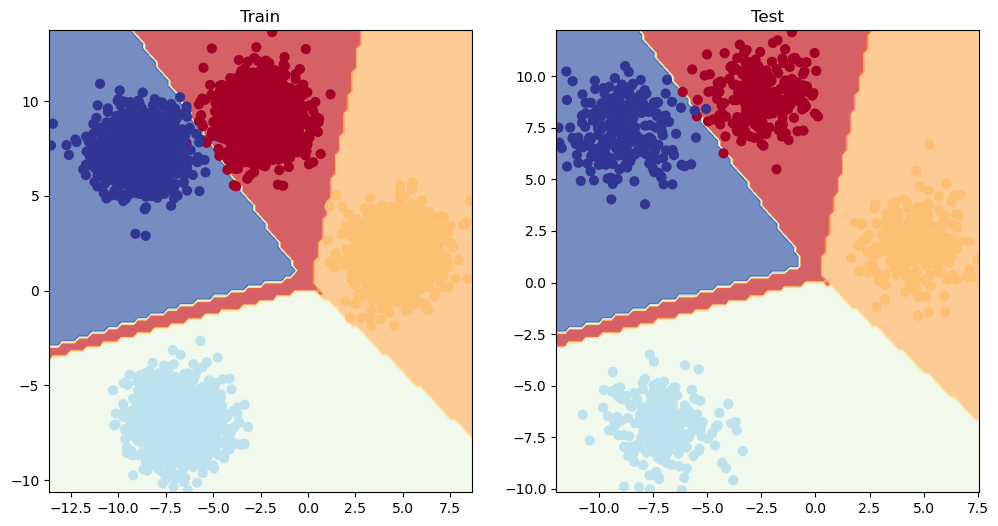

In [208]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model4,XBlobTrain,YBlobTrain)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model4,XBlobTest,YBlobTest)

## 9. A few more classification metrics... (to evaluate our clasification model)

* Accuracy - out of 100 samples, how many does our modelget right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report